In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table

# Earthquake properties
eq_name = "elcentro.txt"
ground_data_name = f"ground_motion_data/{eq_name}"
GROUND_ACC = np.genfromtxt(ground_data_name)        # unit: m/s^2
EQ_dt = 0.02
EQ_duration = EQ_dt * (len(GROUND_ACC) - 1)

# Structural properties
MASS            = np.array([5000])
DAMPING         = np.array([0.05])
BW_PARAM        = np.array([0.1629,  0.3557,  0.0138,  0.8897,  1.8038,  0.0002,  0.0150,  0.8025,  0.1965,  0.0137,  0.8539,  0.0046,  0.1919])
PARAMETER       = np.concatenate((BW_PARAM, MASS, DAMPING))

THRESHOLD_DISP = 0.01
THRESHOLD_ENERGY = 12

# possible actions
ACTION_STAY     = 0
ACTION_INCREASE = 1
ACTION_DECREASE = -1
ACTION_AMOUNT   = 0.01

# probability for exploration
EPSILON = 0.1

# Q-learning step size
ALPHA = 0.5

GAMMA = 1

START_TIME = 0
END_TIME = EQ_duration
EPISODE_DURATION = 0.5 # control the damping ratio value every 0.5 seconds

START_STATE = np.zeros([4, int(EPISODE_DURATION/EQ_dt)])

ACTIONS = [ACTION_STAY, ACTION_INCREASE, ACTION_DECREASE]
num_actions = len(ACTIONS)

In [2]:
from scipy.interpolate import interp1d

def fn_BoucWen_RungeKutta(t, x, parameters, ts, ground_motion):
    g = 9.8
    
    m = parameters[13]              # mass in kg
    damping_ratio = parameters[14]  # unitless
    T = parameters[0]               # period in seconds
    k0 = (2 * np.pi / T)**2 * m     # stiffness in N/m
    Fy = parameters[1] * m * g      # yield force in N
    alpha = parameters[2]
    beta = parameters[3]
    gamma = 1 - beta
    n = parameters[4]
    deltaNu = parameters[5]
    deltaEta = parameters[6]
    zeta0 = parameters[7]
    p = parameters[8]
    q = parameters[9]
    psi = parameters[10]
    deltapsi = parameters[11]
    lambda_ = parameters[12]
    
    wn = 2 * np.pi / T
    c_damping = 2 * damping_ratio * m * wn
    acc = interp1d(ts, ground_motion, fill_value="extrapolate")(t)

    def eta(eps):
        return 1 + deltaEta * eps
    def nu(eps):
        return 1 + deltaNu * eps
    def Zu(eps):
        return (nu(eps) * (beta + gamma))**(-1 / n)
    def zeta1(eps):
        return zeta0 * (1 - np.exp(-p * eps))
    def zeta2(eps):
        return (psi + deltapsi * eps) * (lambda_ + zeta1(eps))
    def h(u_dot, z, eps):
        return 1 - zeta1(eps) * np.exp(-(z * np.sign(u_dot) - q * Zu(eps))**2 / zeta2(eps)**2)

    # BWBN model state-space representation
    x_dot = np.zeros_like(x)
    x_dot[0] = x[1]
    x_dot[1] = (-c_damping / m * x[1] - alpha * k0 / m * x[0] - (1 - alpha) * Fy / m * x[2] - acc)
    x_dot[2] = (h(x[1], x[2], x[3]) / eta(x[3]) * 
                (x[1] - (beta * np.abs(x[1]) * x[2] * np.abs(x[2])**(n - 1) + gamma * x[1] * np.abs(x[2])**n) * nu(x[3])) * k0 / Fy)
    x_dot[3] = (1 - alpha) * k0 / Fy * x[2] * x[1]

    return x_dot


In [3]:
from scipy.integrate import solve_ivp

def fn_Dynamic_Analysis(state, parameters, ground_acc):

    g = 9.8

    # Structural properties
    mass = parameters[13:14]
    damping_ratio = parameters[14:15]
    param = parameters[0:13]

    # Time setup for integration
    dt = 0.02
    td = dt * (len(ground_acc) - 1)
    ts = np.arange(0, td + dt, dt)

    # Integration using solve_ivp
    sol = solve_ivp(fn_BoucWen_RungeKutta, [0, td], state, 
                    args=(np.concatenate((param,mass,damping_ratio)), ts, ground_acc),
                    t_eval=ts, method='RK45', vectorized=False)

    # Results
    t = sol.t
    y = sol.y

    return t, y

In [4]:
def calculate_risk(state):
    bignumber = 1000000
    weight = 0.5

    max_disp = max(state[0,:])
    energy = state[3,-1]

    if max_disp > THRESHOLD_DISP or energy > THRESHOLD_ENERGY:
        risk = bignumber
    else:
        risk = weight * 1/(np.exp(THRESHOLD_DISP - max_disp) - 1 + 1/bignumber) + (1-weight) * 1/(np.exp(THRESHOLD_ENERGY - energy) - 1 + 1/bignumber)

    return risk

def calculate_reward(current_state,next_state):

    current_risk = calculate_risk(current_state)
    next_risk = calculate_risk(next_state)

    return (-next_risk) - (-current_risk) # Note that reward is negative risk. This return is essentially equal to the reduction in risk.

In [5]:
# state: 4 by 25 matrix (4 by 1 vector for each 25 time step)
# state[0]: current displacement (unit: m)
# state[1]: current velocity (unit: m/s)
# state[2]: current hysteresis displacement
# state[3]: current hysteresis energy

def step(state, parameters, ground_acc_fragment, action):

    state_last = state[:,-1]
    
    t, new_state = fn_Dynamic_Analysis(state_last, parameters, ground_acc_fragment)

    if action == ACTION_INCREASE:
        if parameters[-1] > 0.5 - ACTION_AMOUNT:
            parameters[-1] = 0.5
        else:
            parameters[-1] += ACTION_AMOUNT
    elif action == ACTION_DECREASE:
        if parameters[-1] < ACTION_AMOUNT:
            parameters[-1] = 0
        else:
            parameters[-1] -= ACTION_AMOUNT
    elif action == ACTION_STAY:
        pass
    else:
        print("Invalid action")
        print(action)
        assert False

    reward = calculate_reward(state, new_state)
    
    return new_state, t, reward

In [8]:
import tensorflow as tf

class QNetwork:
    def __init__(self, input_shape, num_actions):
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.model = self.build_model(input_shape, num_actions)
        self.model.compile(optimizer='adam', loss='mse')

    def build_model(self, input_shape, num_actions):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=input_shape),       # Input layer: input is state
                tf.keras.layers.Flatten(),                      # Flatten the input
                tf.keras.layers.Dense(128, activation='relu'),  
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(8, activation='relu'),
                tf.keras.layers.Dense(num_actions)              # Output layer: output is Q-value for each action
                ])
        return model

    def predict(self, state):
        return self.model.predict(tf.expand_dims(state, axis=0))

    def train(self, states, targets):
        return self.model.train_on_batch(states, targets)

# Initialize the Q-network
input_shape = START_STATE.shape   # Example input shape for state
q_network = QNetwork(input_shape, num_actions)

In [10]:
# # Define the loss function
# def compute_loss(target_Q, predicted_Q):
#     return tf.reduce_mean(tf.square(target_Q - predicted_Q))

In [9]:
def epsilon_greedy_policy(state, q_network, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(ACTIONS)
    else:
        q_values = q_network.predict(state)
        return ACTIONS[np.argmax(q_values)]

In [10]:
def q_learning_episode(q_network, parameters, ground_acc, step_size=ALPHA):
    state = START_STATE
    rewards = 0.0
    time = 0
    while time < EQ_duration:
        action = epsilon_greedy_policy(state, q_network, EPSILON)

        time_idx = int(time/EQ_dt)
        duration_idx = int(EPISODE_DURATION/EQ_dt)
        if time_idx + duration_idx > len(ground_acc):
            break
        else:
            ground_acc_fragment = ground_acc[time_idx:time_idx+duration_idx]

        next_state, duration, reward = step(state, parameters, ground_acc_fragment, action)
        duration = duration[-1]
        time += duration + EQ_dt

        rewards += reward - 1000000 * abs(action)
        
        # Predict Q-values for the current and next state
        current_q_values = q_network.predict(state)
        next_q_values = q_network.predict(next_state)
        
        # Update Q-value for the chosen action
        target_q_value = reward + GAMMA * np.max(next_q_values)
        current_q_values[0][action] = current_q_values[0][action] + step_size * (target_q_value - current_q_values[0][action])
        
        # Train the Q-network on the updated Q-values
        q_network.train(np.array([state]), current_q_values)
        
        state = next_state
    return rewards

Episode 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Episode 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Episode 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Episode 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Episode 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Episode 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Episode 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Episode 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Episode 36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Episode 39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Episode 43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Episode 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1

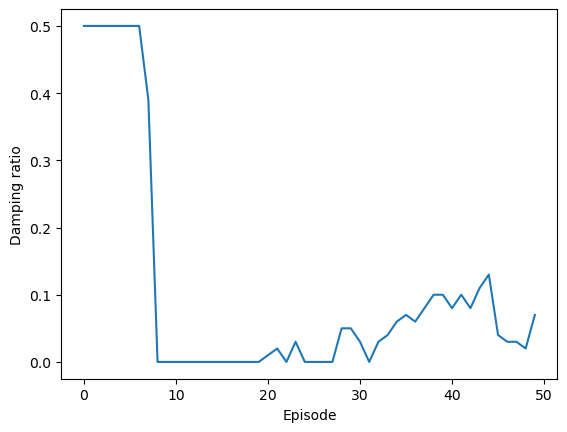

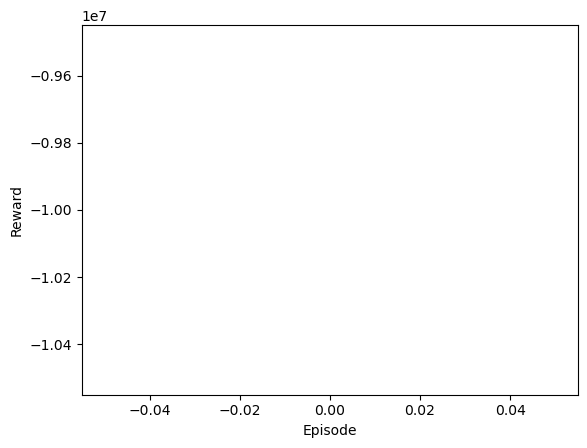

In [11]:
NUM_EPISODES = 50

damping_ratio = []
rewards = []

for j in range(NUM_EPISODES):
    print(f"Episode {j+1}")
    
    reward = q_learning_episode(q_network, PARAMETER, GROUND_ACC, ALPHA)

    rewards.append(reward)

    damping_ratio.append(PARAMETER[-1])

    # print(PARAMETER[-1])
    # plt.plot(time_total,state_total[0,:]*1e3,linewidth=1)
    # plt.xlabel('Time (s)')
    # plt.ylabel('Displacement (mm)')
    # plt.show()

plt.plot(damping_ratio)
plt.xlabel('Episode')
plt.ylabel('Damping ratio')
plt.show()

plt.plot(reward)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()